### Dyna Q implementation

First Learning Q learning , then to Dyna Q

In [94]:
# First Create a simple grid world

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

class GridWorldEnv:
    def __init__(self, grid_size =(5,5), start = (0,0), goal =(4,4), walls = None):
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.walls = walls if walls else []

        self.action_map = {
            0: (-1,0), # up
            1: (1,0) , # down
            2: (0,-1), # left
            3: (0,1)   # right
        }
        # # Create figure once and reuse it
        # self.fig, self.ax = plt.subplots(figsize=(6, 6))
        # plt.ion()  # Turn on interactive mode
        self.reset()

    def reset(self):
        self.agent_pos = list(self.start) # a list [0,0]
        return tuple(self.agent_pos) # (0,0)

    def step(self, action):
        move = self.action_map[action]
        new_pos = [self.agent_pos[0] + move[0], self.agent_pos[1] + move[1]]

        # Boundary check
        new_pos[0] = max(0, min(self.grid_size[0] - 1, new_pos[0]))
        new_pos[1] = max(0, min(self.grid_size[1] - 1, new_pos[1]))

        # Wall check : if next cell is a wall , stay in place
        if tuple(new_pos) not in self.walls:
            self.agent_pos = new_pos

        done = (tuple(self.agent_pos) == self.goal)
        reward = 1 if done else -0.01

        return tuple(self.agent_pos), reward, done

    def render(self, last_action=None):
        if not hasattr(self, 'fig') or not hasattr(self, 'ax'):
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            plt.ion()

        # Clear the current axes
        self.ax.clear()

        # Create grid visualization
        grid = np.zeros(self.grid_size)
        grid[self.goal] = 0.8  # Goal position

        self.ax.imshow(grid, cmap='gray', origin='lower', vmin=0, vmax=1)

        # Draw walls
        for wy, wx in self.walls:
            self.ax.add_patch(plt.Rectangle((wx - 0.5, wy - 0.5), 1, 1, color='dimgray'))


        # Grid lines
        for i in range(self.grid_size[0] + 1):
            self.ax.axhline(i - 0.5, color='white', linewidth=1)
        for j in range(self.grid_size[1] + 1):
            self.ax.axvline(j - 0.5, color='white', linewidth=1)

        # set up axis labels and ticks
        self.ax.set_xticks(range(self.grid_size[1]))
        self.ax.set_yticks(range(self.grid_size[0]))
        self.ax.set_xticklabels(range(self.grid_size[1]))
        self.ax.set_yticklabels(range(self.grid_size[0]))


        # Agent visualization
        y, x = self.agent_pos

        if last_action is not None:
            # Show arrow for last action
            dx, dy = {
                0: (0, -0.3),   # up
                1: (0, 0.3),    # down
                2: (-0.3, 0),   # left
                3: (0.3, 0),    # right
            }[last_action]
            self.ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.15,
                         fc='red', ec='red', linewidth=2)

        # Always show agent position as a circle
        self.ax.plot(x, y, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2)

        # Mark goal
        goal_x, goal_y = self.goal[1], self.goal[0]
        self.ax.plot(goal_x, goal_y, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1)

        self.ax.set_title(f"GridWorld - Agent at {self.agent_pos}", fontsize=14, fontweight='bold')
        self.ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        self.ax.set_ylim(-0.5, self.grid_size[0] - 0.5)

        # Add axis labels
        self.ax.set_xlabel('X (Column)', fontsize=12)
        self.ax.set_ylabel('Y (Row)', fontsize=12)

        # Update the display
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        """Close the figure when done"""
        plt.close(self.fig)


# Q value update map
def plot_q_table_heatmap(Q, env):
    max_Q = np.max(Q, axis=2)  # shape = (rows, cols)

    fig, ax = plt.subplots(figsize=(6, 6))
    c = ax.imshow(max_Q, cmap='viridis', origin='upper')

    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            q_val = max_Q[i, j]
            ax.text(j, i, f"{q_val:.2f}", va='center', ha='center', color='white', fontsize=8)

    ax.set_title("Max Q-value per State")
    ax.set_xticks(np.arange(env.grid_size[1]))
    ax.set_yticks(np.arange(env.grid_size[0]))
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    fig.colorbar(c, ax=ax)
    # plt.gca().invert_yaxis()
    plt.show()


# Testing the Gridworl environment

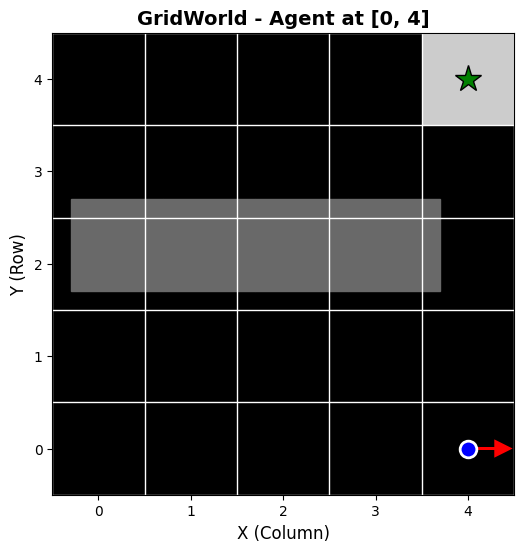

In [103]:
%matplotlib inline
walls = [(2, i) for i in range(5)]  # entire row 2 is blocked
walls.remove((2, 4))  # leave one gap at (2,4)

env = GridWorldEnv(walls=walls)
state = env.reset()
env.render()

for step in range(10):
  action = np.random.randint(0,4) # 0-3 actions
  next_state, reward, done = env.step(action)
  print(f"Step {step+1}: Action={action}, Position={next_state}, Reward={reward}")
  env.render(last_action=action)
  time.sleep(0.5)

  if done:
    print("Goal reached")
    break

env.close()

# Define Q table, epsilon greedy policy

In [ ]:
# Environment setup
env = GridWorldEnv()
state_shape = env.grid_size
num_action = 4

# Lets first define the 3D Q matrix or Q table, Q[s, a] => Q[state_row, state_col, action]
Q = np.zeros((state_shape[0], state_shape[1], num_action)) # This sets up a Q-value for each (state, action) pair.

# Implement Epsilon greedy action selection
def choose_action(state, Q, Epsilon):
    """
    Given Q[state_row, state_row,:] and E , choose action with probabilty E, and random action with Probability 1 - E
    """
    if np.random.rand() < Epsilon:
        return np.random.randint(4) # Exploration
    else:
        row, col = state
        return np.argmax(Q[row, col]) # Greedy action = Exploitation


# Define Hyperparameters


In [13]:
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.2 # exploration rate
num_episodes = 100
max_steps = 100

# Implement Q learning update
"what is the best action to take from any state to eventually get the most reward"

Goal:  
Learn the optimal action-value function Q(s, a), which estimates the expected cumulative reward when taking action a in state s, and following the optimal policy thereafter.

Update Equation:

  Q(s, a) ← Q(s, a) + α [ r + γ * max_a' Q(s', a') - Q(s, a) ]

Where:
- s, a : Current state and action  
- r    : Reward received  
- s'   : Next state after action a  
- α    : Learning rate  
- γ    : Discount factor  
- max_a' Q(s', a') : Estimated optimal future value from next state

Explanation:  
At each time step, the Q-value is updated using 1-step Temporal Difference (TD) learning.  
It shifts the current estimate Q(s, a) toward the more accurate target value r + γ * max_a' Q(s', a').



In [ ]:
walls = [(2,i) for i in range(5)]
walls.remove((2,4))
env = GridWorldEnv(walls=walls)
state_shape = env.grid_size
num_action = 4
Q = np.zeros((state_shape[0],state_shape[1], num_action))

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for steps in range(max_steps):
        action = choose_action(state, Q, epsilon)
        next_state, reward, done = env.step(action)

        # unpack state coordinates
        row, col = state
        next_row, next_col = next_state

        # Q - learning update
        best_next_action = np.argmax(Q[next_row, next_col])
        td_target = reward + gamma * Q[next_row, next_col, best_next_action]
        td_error = td_target - Q[row, col, action]
        Q[row, col, action] += alpha*td_error

        # Update state
        state = next_state
        total_reward += reward

        if episode % 10 == 0:
            clear_output(wait=True)
            print(f"Episode {episode}")

            # Setup combined figure
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # LEFT: Agent grid
            axes[0].set_title(f"GridWorld - Agent at {env.agent_pos}")
            grid = np.zeros(env.grid_size)
            grid[env.goal] = 0.8
            axes[0].imshow(grid, cmap='gray', origin='upper', vmin=0, vmax=1)
            # Draw walls manually
            for wy, wx in env.walls:
                axes[0].add_patch(plt.Rectangle((wx - 0.5, wy - 0.5), 1, 1, color='dimgray'))


            # Agent + goal rendering
            y, x = env.agent_pos
            dx, dy = {
                0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)
            }.get(action, (0, 0))
            axes[0].arrow(x, y, dx, dy, head_width=0.15, head_length=0.15, fc='red', ec='red', linewidth=2)
            axes[0].plot(x, y, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2)
            goal_x, goal_y = env.goal[1], env.goal[0]
            axes[0].plot(goal_x, goal_y, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1)

            # Grid formatting
            for ax in axes:
                ax.set_xticks(range(env.grid_size[1]))
                ax.set_yticks(range(env.grid_size[0]))
                ax.set_xticklabels(range(env.grid_size[1]))
                ax.set_yticklabels(range(env.grid_size[0]))
                ax.set_xlim(-0.5, env.grid_size[1]-0.5)
                ax.set_ylim(-0.5, env.grid_size[0]-0.5)
                ax.grid(True)

            # RIGHT: Q-value heatmap
            max_Q = np.max(Q, axis=2)
            im = axes[1].imshow(max_Q, cmap='viridis', origin='upper')
            axes[1].set_title("Max Q-value per State")
            for i in range(env.grid_size[0]):
                for j in range(env.grid_size[1]):
                    q_val = max_Q[i, j]
                    axes[1].text(j, i, f"{q_val:.2f}", va='center', ha='center', color='white', fontsize=8)
            fig.colorbar(im, ax=axes[1], shrink=0.7)

            plt.tight_layout()
            plt.show()
            # time.sleep(0.5)


        if done:
            print(f" Episode {episode +1} finished in {step +1} steps. Total reward : {total_reward}")
            break

env.close()


# Visualize the Best Path after Q learning update

In [87]:
def visualize_greedy_path(Q, env, max_steps=50):
    state = env.reset() # move to initial state
    path = [state] # list of tuples
    actions = []

    for _ in range(max_steps):
        row , col = state
        action = np.argmax(Q[row, col])
        actions.append(action)

        next_state , _ , done = env.step(action)
        path.append(next_state)
        state = next_state
        if done:
            break

    # Now plot the full path
    fig, ax = plt.subplots(figsize=(6, 6))
    grid = np.zeros(env.grid_size)
    grid[env.goal] = 0.8
    ax.imshow(grid, cmap='gray', origin='lower', vmin=0, vmax=1)
    ax.set_title("Greedy Path from Start to Goal")

    for idx, (pos, action) in enumerate(zip(path[:-1], actions)):
        y, x = pos
        dx, dy = {
            0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)
        }[action]
        ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.15,
                 fc='blue', ec='blue', linewidth=2)

    # Start and Goal
    sx, sy = path[0][1], path[0][0]
    gx, gy = env.goal[1], env.goal[0]
    ax.plot(sx, sy, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2, label='Start')
    ax.plot(gx, gy, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1, label='Goal')

    ax.set_xlim(-0.5, env.grid_size[1] - 0.5)
    ax.set_ylim(-0.5, env.grid_size[0] - 0.5)
    ax.set_xticks(range(env.grid_size[1]))
    ax.set_yticks(range(env.grid_size[0]))
    ax.set_xticklabels(range(env.grid_size[1]))
    ax.set_yticklabels(range(env.grid_size[0]))
    ax.grid(True)
    ax.legend()
    plt.show()

# Plot steps per episode vs episodes
def steps_per_episode_plot(steps_per_episode):
    plt.figure(figsize=(10, 5))
    plt.plot(steps_per_episode, label='Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title('Dyna-Q Learning: Steps per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()

# visualize_greedy_path(Q, env)

In [88]:
def render_dyna_q(env, agent, episode, action):
    clear_output(wait=True)
    print(f"Episode {episode}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # === LEFT: Gridworld ===
    axes[0].set_title(f"Dyna-Q: Agent at {env.agent_pos}")
    grid = np.zeros(env.grid_size)
    grid[env.goal] = 0.8
    axes[0].imshow(grid, cmap='gray', origin='upper', vmin=0, vmax=1)

    # Draw walls
    for wy, wx in env.walls:
        axes[0].add_patch(plt.Rectangle((wx - 0.5, wy - 0.5), 1, 1, color='dimgray'))

    # Agent arrow + circle

    y, x = env.agent_pos
    if 'action' in locals():
      dx, dy = {
          0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)
      }.get(action, (0, 0))
      axes[0].arrow(x, y, dx, dy, head_width=0.15, head_length=0.15, fc='red', ec='red', linewidth=2)
      axes[0].plot(x, y, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2)

    # Goal
    goal_x, goal_y = env.goal[1], env.goal[0]
    axes[0].plot(goal_x, goal_y, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1)

    # Grid formatting
    for ax in axes:
        ax.set_xticks(range(env.grid_size[1]))
        ax.set_yticks(range(env.grid_size[0]))
        ax.set_xticklabels(range(env.grid_size[1]))
        ax.set_yticklabels(range(env.grid_size[0]))
        ax.set_xlim(-0.5, env.grid_size[1] - 0.5)
        ax.set_ylim(-0.5, env.grid_size[0] - 0.5)
        ax.grid(True)

    # === RIGHT: Q-table ===
    max_Q = np.max(agent.Q, axis=2)
    im = axes[1].imshow(max_Q, cmap='viridis', origin='upper')
    axes[1].set_title("Max Q-value per State")
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            q_val = max_Q[i, j]
            axes[1].text(j, i, f"{q_val:.2f}", va='center', ha='center', color='white', fontsize=8)

    fig.colorbar(im, ax=axes[1], shrink=0.7)
    plt.tight_layout()
    plt.show()

# Dyna Q => Q Learning + Planning

## for each Q learning steps , we do multiple planning steps

here we consider a Deterministic model (instead of full probabilisty bellman model) for planning, update
this simple model store all the State action and maps to next action and reward.

###Planning:
We simulate experience by randomly sampling from the stored state-action pairs,  
and apply the same Q-learning TD update to those simulated transitions.

**Key Advantage:**  
Faster learning cause of direct experience + internal simulation (planning).

In [103]:
import random

class DynaQAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=5) -> None:
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps

        self.Q = np.zeros((env.grid_size[0], env.grid_size[1], 4 ))
        self.model = {} # for planning : Deterministic Sample Model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(4)
        else:
            action = np.argmax(self.Q[state[0], state[1]])
        return action

    def update_real(self, state, action, reward, next_state):
        # 1 step Q learning update
        if next_state is None:
            td_target = reward # Terminal state
        else:
            best_action = np.argmax(self.Q[next_state[0], next_state[1]])
            td_target = reward + self.gamma * self.Q[next_state[0], next_state[1], best_action]

        td_error = td_target - self.Q[state[0],state[1], action]
        self.Q[state[0],state[1], action] += self.alpha * td_error

    def update_model(self, state, action, reward, next_state):
        self.model[(state, action)] = next_state, reward

    def planning(self):
        if not self.model: # only do planning if we have experience to learn
            return
        for _ in range(self.planning_steps):
            state , action = random.choice(list(self.model.keys()))
            next_state, reward = self.model[(state, action)]

            if next_state is None:
                continue
            self.update_real(state, action, reward, next_state)

In [133]:
# Training loop
def train_dyna_q(env, planning_steps, num_episodes=100, max_steps=300,gamma=0.95 ,visualize=False):
    agent = DynaQAgent(env, alpha=0.1, gamma=gamma, epsilon=0.1, planning_steps=planning_steps)
    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state , reward, done = env.step(action)

            agent.update_real(state, action, reward, next_state)
            if not done: # Only update model with non terminal state
                agent.update_model(state, action, reward, next_state)
            else:
                agent.update_model(state, action, reward, None)

            agent.planning()

            total_reward += reward
            state = next_state
            if done:
                rewards_per_episode.append(total_reward)
                steps_per_episode.append(step + 1)
                break
        else:
            steps_per_episode.append(max_steps) # only append if loop completes without break


        # Visualization for Dyna Q -> move this inner forloop, this will slowdown the training, need to update better visualization
        if visualize and episode % 10 == 0:
            render_dyna_q(env, agent, episode, action)

    return steps_per_episode,  rewards_per_episode ,agent



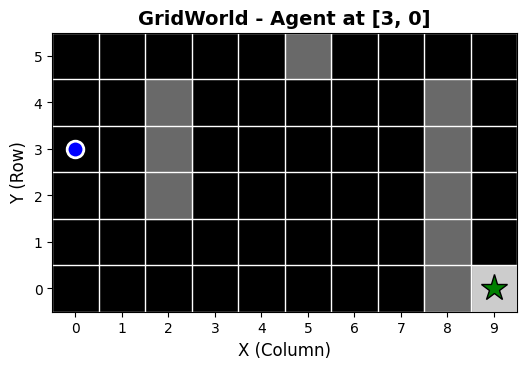

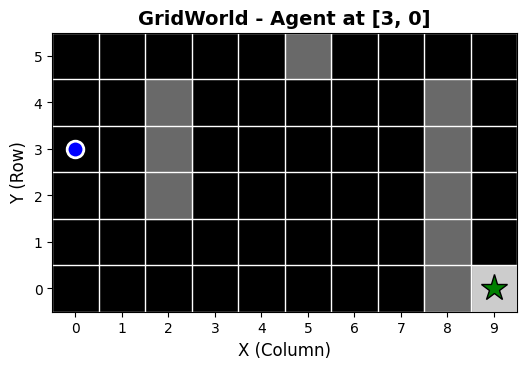

In [126]:
walls = [(2, 2), (3, 2), (4, 2),
          (5, 5),
         (0,8),(1, 8),(2,8),(3,8) ,(4, 8)]
env = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=walls)
env.render()

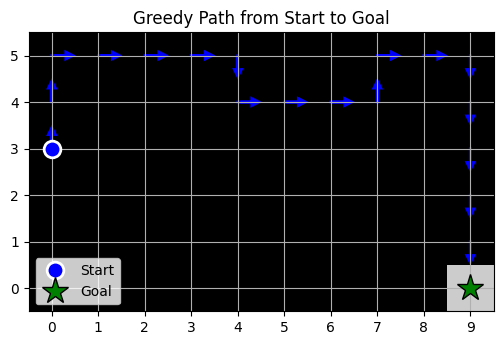

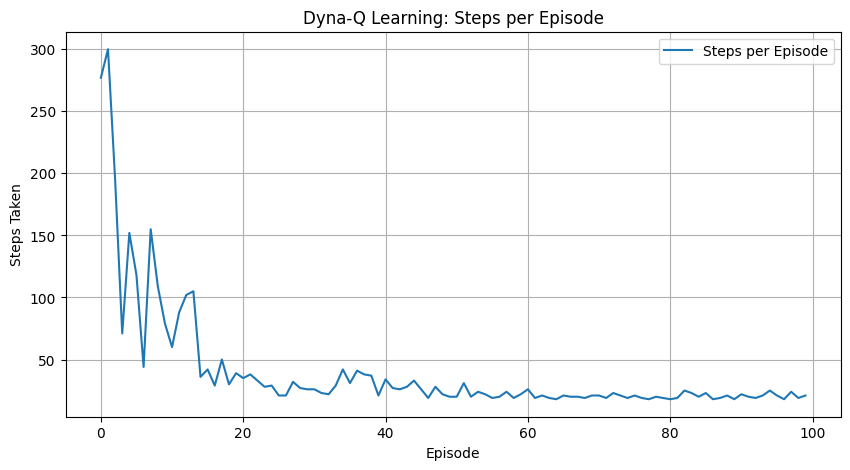

In [134]:
step_per_episode,_ , agent = train_dyna_q(env, planning_steps=5, num_episodes=100, visualize=False)
visualize_greedy_path(agent.Q, env)
steps_per_episode_plot(step_per_episode)

In [131]:
walls = [(2, 2), (3, 2), (4, 2),
          (5, 5),
         (0,8),(1, 8),(2,8),(3,8) ,(4, 8)]
# env = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=walls)
results = {}
for p in [0, 5, 50]:
    env = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=walls)
    steps, _,_ = train_dyna_q(env, planning_steps=p, num_episodes=100, max_steps=1000,visualize=False)
    results[p] = steps

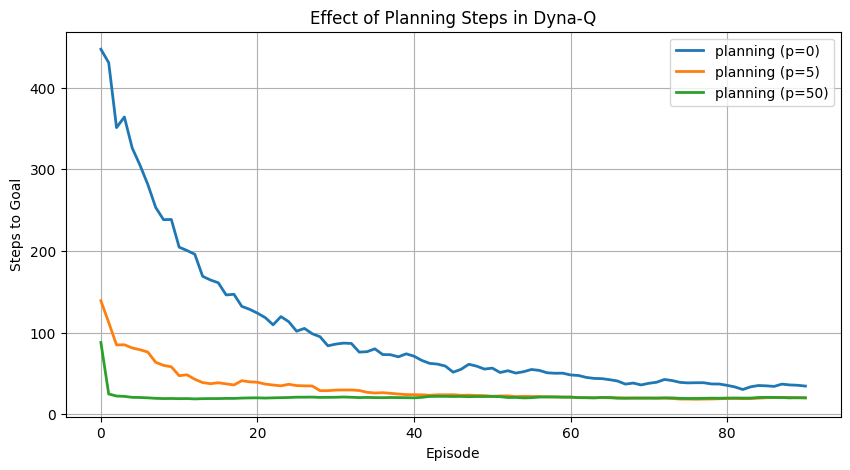

In [132]:
# walls = [
#     [(2,0),(2,1),(2,2),(2, 3), (2, 4), (2, 5),(2, 6),(2, 7),(2, 8)],
#  [(2,1),(2,2),(2, 3), (2, 4), (2, 5),(2, 6),(2, 7),(2, 8),(2,9)]]
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
for p, steps in results.items():
    # plt.plot(steps, label=f'Planning Steps = {p}')
    smoothed = moving_average(steps, window_size=10)
    plt.plot(range(len(smoothed)), smoothed, label=f'planning (p={p})', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Effect of Planning Steps in Dyna-Q")
plt.legend()
plt.grid(True)
plt.show()

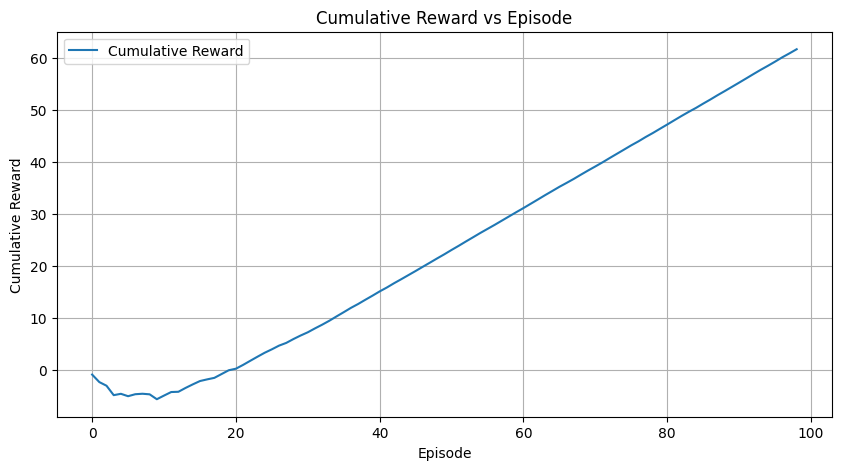

In [135]:
# Cummulative reward vs Time steps
def plot_rewards(rewards_per_episode):
    cumulative_rewards = np.cumsum(rewards_per_episode)
    timesteps = np.arange(len(cumulative_rewards))

    plt.figure(figsize=(10,5))
    plt.plot(timesteps, cumulative_rewards, label='Cumulative Reward')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward vs Episode")
    plt.grid(True)
    plt.legend()
    plt.show()

steps, rewards, agent = train_dyna_q(env, planning_steps=5, num_episodes=100, visualize=False)
plot_rewards(rewards)


# Observsation : Cummulative reward vs Timesteps

In early episodes, the agent gets low or negative reward (mostly -0.01 per step, maybe not reaching the goal).

Once learning improves (say, from episode ~20 onward), it starts reaching the goal more often, collecting positive rewards (+1), which lifts the curve steadily.

The linear upward trend later on indicates the agent is consistently reaching the goal quickly — learning has stabilized.


In [138]:
# Now lets change the environment :
initial_walls = [
    (2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8)
]
changed_walls = [
    (2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9)
]
# Modify the training loop to change the wall after episode 40
def train_dyna_q_changing_walls(env, planning_steps, num_episodes=100, max_steps=300, gamma=0.95, visualize=False):
    agent = DynaQAgent(env, alpha=0.1, gamma=gamma, epsilon=0.1, planning_steps=planning_steps)
    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(num_episodes):
        if episode == 40:
            # Change walls mid-training
            env.walls = changed_walls
            print("Environment changed at episode 40")

        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            agent.update_real(state, action, reward, next_state)
            if not done:
                agent.update_model(state, action, reward, next_state)
            else:
                agent.update_model(state, action, reward, None)

            agent.planning()
            total_reward += reward
            state = next_state

            if done:
                steps_per_episode.append(step + 1)
                rewards_per_episode.append(total_reward)
                break
        else:
            steps_per_episode.append(max_steps)
            rewards_per_episode.append(total_reward)

        if visualize and episode % 10 == 0:
            render_dyna_q(env, agent, episode, action)

    return steps_per_episode, rewards_per_episode, agent



Environment changed at episode 40


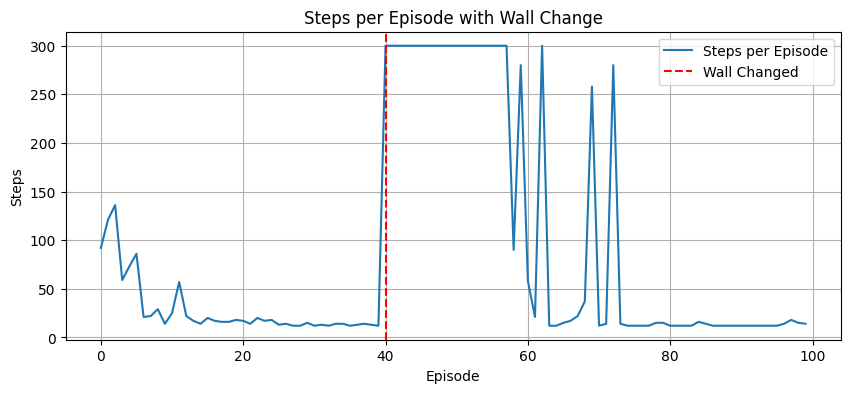

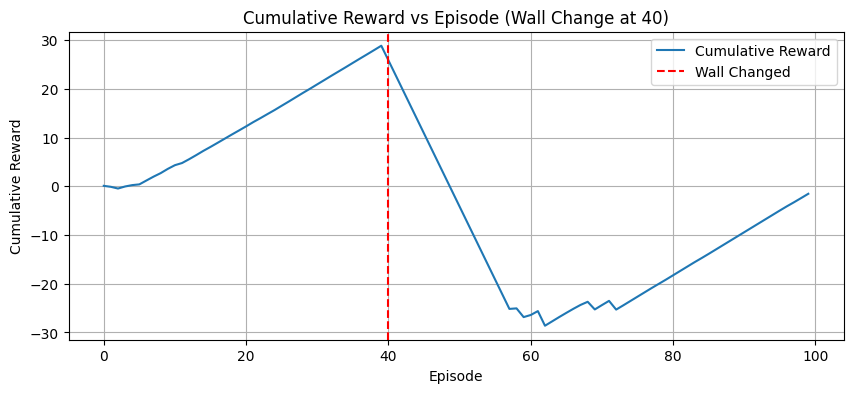

In [139]:
steps, rewards, agent = train_dyna_q_changing_walls(
    GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=initial_walls),
    planning_steps=5,
    num_episodes=100,
    visualize=False
)

# Plot Steps
plt.figure(figsize=(10, 4))
plt.plot(steps, label="Steps per Episode")
plt.axvline(x=40, color='red', linestyle='--', label='Wall Changed')
plt.title("Steps per Episode with Wall Change")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.grid(True)
plt.legend()
plt.show()

# Plot Cumulative Rewards
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(10, 4))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.axvline(x=40, color='red', linestyle='--', label='Wall Changed')
plt.title("Cumulative Reward vs Episode (Wall Change at 40)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.legend()
plt.show()


# Observation:
 Observations: Wall Change in Dyna-Q

🔹 Pre-Change Learning (Episodes 0–39):

The agent rapidly learns the optimal path.

Steps per episode drop consistently.

Cumulative reward increases steadily.

🔹 Post-Change Impact (Immediately after Episode 40):

Sudden spike in steps per episode due to failure in reaching the goal (old path invalidated).

Cumulative reward drops sharply due to repeated penalties (e.g., -0.01 per step).

🔹 Recovery Phase (Episodes 50–70):

Agent re-learns a new valid path using both real and simulated experience.

Steps per episode gradually decrease again.

Cumulative reward begins rising after the dip.
